# NLP Deep Dive with RNNs

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 3.9 MB/s 
     |████████████████████████████████| 4.7 MB 11.9 MB/s 
     |████████████████████████████████| 365 kB 55.6 MB/s 
     |████████████████████████████████| 1.3 MB 45.4 MB/s 
     |████████████████████████████████| 212 kB 15.0 MB/s 
     |████████████████████████████████| 115 kB 53.7 MB/s 
     |████████████████████████████████| 120 kB 50.7 MB/s 
     |████████████████████████████████| 127 kB 52.2 MB/s 
     |████████████████████████████████| 6.6 MB 65.9 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML

In [3]:
from fastai.text.all import * 

In [4]:
path = untar_data(URLs.IMDB)

In [5]:
path.ls()

(#7) [Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/test')]

In [6]:
files = get_text_files(path, folders=['train', 'test', 'unsup'])

In [7]:
txt = files[0].open().read(); txt

"I love this movie, Clint Eastwood is fantastic. It's a very dark, mysterious movie set mostly at night. Within the adult scene in 80's New Orleans. With Clints character's sexual cravings he begins to cross the killers domain and realises the killer is not only very much in touch with him, but similar to his desires in many ways. It's a great story, simple stalker type movie but done superbly. Twists and turns throughout the film. It's a forgotten or perhaps not known very well Eastwood gem, not a dirty harry shoot em up though, a more dark, personal film involving Clints life orientating between father to his girls and his seedy sexual desires in the night of New Orleans, to his non stop crusade to bring a dark and mysterious stalker to justice. A wonderful film, great acting and suspense throughout. Very enjoyable. 10 out of 10"

## Tokenization

In [8]:
spacy = WordTokenizer()
spacy

In [9]:
# spacy tokenizes our text with the deafult settings here, tokenizing by spaces 
toks = first(spacy([txt])); toks

(#171) ['I','love','this','movie',',','Clint','Eastwood','is','fantastic','.'...]

In [10]:
type(toks)

fastcore.foundation.L

In [11]:
# hmm is this fastai function really necessary? just gets a string representation to show more values... 🤷‍♀️
coll_repr(toks, 50)

'(#171) [\'I\',\'love\',\'this\',\'movie\',\',\',\'Clint\',\'Eastwood\',\'is\',\'fantastic\',\'.\',\'It\',"\'s",\'a\',\'very\',\'dark\',\',\',\'mysterious\',\'movie\',\'set\',\'mostly\',\'at\',\'night\',\'.\',\'Within\',\'the\',\'adult\',\'scene\',\'in\',\'80\',"\'s",\'New\',\'Orleans\',\'.\',\'With\',\'Clints\',\'character\',"\'s",\'sexual\',\'cravings\',\'he\',\'begins\',\'to\',\'cross\',\'the\',\'killers\',\'domain\',\'and\',\'realises\',\'the\',\'killer\'...]'

In [12]:
# now lets use fastai's tokenizer 
tkn = Tokenizer(spacy)
coll_repr(tkn(txt), 50)
# we see fastai's special tokens representing "beginning of stream", "capital letter incoming!" etc. 

'(#188) [\'xxbos\',\'i\',\'love\',\'this\',\'movie\',\',\',\'xxmaj\',\'clint\',\'xxmaj\',\'eastwood\',\'is\',\'fantastic\',\'.\',\'xxmaj\',\'it\',"\'s",\'a\',\'very\',\'dark\',\',\',\'mysterious\',\'movie\',\'set\',\'mostly\',\'at\',\'night\',\'.\',\'xxmaj\',\'within\',\'the\',\'adult\',\'scene\',\'in\',\'80\',"\'s",\'xxmaj\',\'new\',\'xxmaj\',\'orleans\',\'.\',\'xxmaj\',\'with\',\'xxmaj\',\'clints\',\'character\',"\'s",\'sexual\',\'cravings\',\'he\',\'begins\'...]'

In [13]:
list(tkn('hello I\'m going to use an invalid english word tootyfruitcake'))

['xxbos',
 'hello',
 'xxmaj',
 'i',
 "'m",
 'going',
 'to',
 'use',
 'an',
 'invalid',
 'english',
 'word',
 'tootyfruitcake']

In [14]:
coll_repr(tkn('&copy;     Fast.ai www.fast.ai/INDEX'), 31)

"(#11) ['xxbos','©','xxmaj','fast.ai','xxrep','3','w','.fast.ai','/','xxup','index']"

## Subword Tokenization

In [15]:
txts = L(f.open().read() for f in files[:2000])

In [16]:
len(txts)

2000

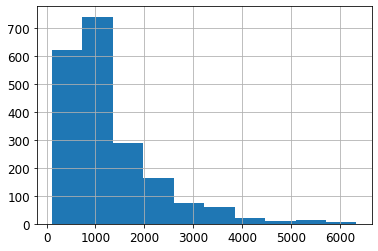

In [17]:
pd.Series([len(t) for t in txts]).hist();

In [18]:
sp = SubwordTokenizer(vocab_sz=1000)
sp

In [19]:
sp.setup(txts)
" ".join(first(sp([txt]))[:40])

"▁I ▁love ▁this ▁movie , ▁C lin t ▁E ast wood ▁is ▁fan ta s tic . ▁It ' s ▁a ▁very ▁d ar k , ▁my ster ious ▁movie ▁set ▁most ly ▁at ▁night . ▁With in ▁the ▁a"

In [20]:
def subword(sz):
  """
  tokenizes our hardcoded text with a given subword token size 
  """
  sp = SubwordTokenizer(vocab_sz=sz)
  sp.setup(txts)
  return " ".join(first(sp([txt]))[:40])

In [21]:
subword(200)

"▁I ▁ l o ve ▁this ▁movie , ▁ C l in t ▁ E a st w o o d ▁is ▁f an t a st ic . ▁I t ' s ▁a ▁ v er y ▁d ar"

In [22]:
sp.setup??

## Numericalization

We need to map each token to an index so we can represent words in our model 

In [23]:
tkn(txts[0])

(#188) ['xxbos','i','love','this','movie',',','xxmaj','clint','xxmaj','eastwood'...]

In [24]:
# tokenize the first 200 documents 
toks200 = txts[:200].map(tkn)
toks200[0]

(#188) ['xxbos','i','love','this','movie',',','xxmaj','clint','xxmaj','eastwood'...]

In [25]:
# set indices for the tokens that occur in the first 200 documents
num = Numericalize()
num.setup(toks200)
list(num.vocab)[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the']

In [26]:
toks = toks200[0] 
nums = num(toks)[:50]; nums

TensorText([   2,   19,  139,   22,   32,   10,    8,    0,    8,    0,   16,  559,   11,    8,   18,   23,   13,   70,  480,   10, 1028,   32,  306,  610,   46,  319,   11,    8,  560,    9,  611,
             166,   17, 1029,   23,    8,  186,    8,    0,   11,    8,   29,    8,    0,  125,   23,  481,    0,   42, 1573])

In [27]:
' '.join(num.vocab[i] for i in nums)

"xxbos i love this movie , xxmaj xxunk xxmaj xxunk is fantastic . xxmaj it 's a very dark , mysterious movie set mostly at night . xxmaj within the adult scene in 80 's xxmaj new xxmaj xxunk . xxmaj with xxmaj xxunk character 's sexual xxunk he begins"

In [28]:
txts[0]

"I love this movie, Clint Eastwood is fantastic. It's a very dark, mysterious movie set mostly at night. Within the adult scene in 80's New Orleans. With Clints character's sexual cravings he begins to cross the killers domain and realises the killer is not only very much in touch with him, but similar to his desires in many ways. It's a great story, simple stalker type movie but done superbly. Twists and turns throughout the film. It's a forgotten or perhaps not known very well Eastwood gem, not a dirty harry shoot em up though, a more dark, personal film involving Clints life orientating between father to his girls and his seedy sexual desires in the night of New Orleans, to his non stop crusade to bring a dark and mysterious stalker to justice. A wonderful film, great acting and suspense throughout. Very enjoyable. 10 out of 10"

## Put the numbers in a model 

In [29]:
nums200 = toks200.map(num)
nums200[0]

TensorText([   2,   19,  139,   22,   32,   10,    8,    0,    8,    0,   16,  559,   11,    8,   18,   23,   13,   70,  480,   10, 1028,   32,  306,  610,   46,  319,   11,    8,  560,    9,  611,
             166,   17, 1029,   23,    8,  186,    8,    0,   11,    8,   29,    8,    0,  125,   23,  481,    0,   42, 1573,   15,    0,    9, 1253,    0,   12,    0,    9,  683,   16,   37,   73,
              70,   88,   17,  887,   29,  121,   10,   31, 1030,   15,   39,    0,   17,  137,  684,   11,    8,   18,   23,   13,  104,   78,   10,  685,    0,  612,   32,   31,  230,    0,   11,
               8, 1574,   12,  888,  889,    9,   30,   11,    8,   18,   23,   13,    0,   55,  260,   37,  516,   70,   87,    8,    0,  890,   10,   37,   13,    0,    0, 1575,    0,   71,  163,
              10,   13,   59,  480,   10,  686,   30,  891,    8,    0,  116,    0,  238,  261,   15,   39, 1031,   12,   39,    0,  481,    0,   17,    9,  319,   14,    8,  186,    8,    0,   10,
          

In [30]:
# language model dataloader
LMDataLoader??

In [31]:
dl = LMDataLoader(nums200)

In [32]:
x, y = first(dl)
x.shape, y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

In [33]:
x

LMTensorText([[   2,   19,  139,  ...,   31, 1030,   15],
              [ 691,  100,   14,  ...,    8,    0,    8],
              [ 174,  705,   11,  ...,   20, 1291,   20],
              ...,
              [1341,   12,  266,  ...,   18,   16,  267],
              [  10,    8, 2112,  ...,    0,   17,   13],
              [  65,   33,  138,  ...,   15,  190,   67]])

In [34]:
# LmTensorText -> TensorText -> TensorBase (fastai) -> Tensor (pytorch)
TensorBase??

In [35]:
 %pprint

Pretty printing has been turned OFF


In [36]:
[num.vocab[a] for a in x[0,:]]

['xxbos', 'i', 'love', 'this', 'movie', ',', 'xxmaj', 'xxunk', 'xxmaj', 'xxunk', 'is', 'fantastic', '.', 'xxmaj', 'it', "'s", 'a', 'very', 'dark', ',', 'mysterious', 'movie', 'set', 'mostly', 'at', 'night', '.', 'xxmaj', 'within', 'the', 'adult', 'scene', 'in', '80', "'s", 'xxmaj', 'new', 'xxmaj', 'xxunk', '.', 'xxmaj', 'with', 'xxmaj', 'xxunk', 'character', "'s", 'sexual', 'xxunk', 'he', 'begins', 'to', 'xxunk', 'the', 'killers', 'xxunk', 'and', 'xxunk', 'the', 'killer', 'is', 'not', 'only', 'very', 'much', 'in', 'touch', 'with', 'him', ',', 'but', 'similar', 'to']

In [37]:
[num.vocab[a] for a in y[0,:]]

['i', 'love', 'this', 'movie', ',', 'xxmaj', 'xxunk', 'xxmaj', 'xxunk', 'is', 'fantastic', '.', 'xxmaj', 'it', "'s", 'a', 'very', 'dark', ',', 'mysterious', 'movie', 'set', 'mostly', 'at', 'night', '.', 'xxmaj', 'within', 'the', 'adult', 'scene', 'in', '80', "'s", 'xxmaj', 'new', 'xxmaj', 'xxunk', '.', 'xxmaj', 'with', 'xxmaj', 'xxunk', 'character', "'s", 'sexual', 'xxunk', 'he', 'begins', 'to', 'xxunk', 'the', 'killers', 'xxunk', 'and', 'xxunk', 'the', 'killer', 'is', 'not', 'only', 'very', 'much', 'in', 'touch', 'with', 'him', ',', 'but', 'similar', 'to', 'his']

So the "label" is just the same sequence but offset by one token, i.e. containing the final "completed" token for the sequence. Interesting... 

From book RE using built-in APIs to handle numericalization and tokenization. i.e., you don't actually have to manually set up these steps, they're built into TextBLock 

*fastai handles tokenization and numericalization automatically when TextBlock is passed to DataBlock. All of the arguments that can be passed to Tokenize and Numericalize can also be passed to TextBlock. In the next chapter we'll discuss the easiest ways to run each of these steps separately, to ease debugging—but you can always just debug by running them manually on a subset of your data as shown in the previous sections. And don't forget about DataBlock's handy summary method, which is very useful for debugging data issues.*

In [38]:
TextBlock??

In [39]:
path

Path('/root/.fastai/data/imdb')

In [40]:
# returns a list of file paths given the imdb base path 
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

In [ ]:
# data loaders: language model 
dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, 
    splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj imagine yourself trapped inside a museum of the dark middle xxmaj ages and a resurrected vampire and his maniacal sidekick are chasing you . xxmaj where is the absolute last place you want to hide ? xxmaj i 'd say inside the uncanny xxmaj virgin of xxmaj nuremberg torture device , because there 's a good risk you 'll get brutally spiked to death . xxmaj and yet , the elderly lady in this film stupidly runs into","xxmaj imagine yourself trapped inside a museum of the dark middle xxmaj ages and a resurrected vampire and his maniacal sidekick are chasing you . xxmaj where is the absolute last place you want to hide ? xxmaj i 'd say inside the uncanny xxmaj virgin of xxmaj nuremberg torture device , because there 's a good risk you 'll get brutally spiked to death . xxmaj and yet , the elderly lady in this film stupidly runs into her"
1,"rainbow xxmaj connection , "" i 'm xxmaj going to go xxmaj back xxmaj there xxmaj someday , "" and "" movin ' xxmaj right xxmaj along . "" xxmaj the xxmaj muppets also use many forms of transportation in this movie . xxmaj kermit rides a bike , xxmaj fozzie drives a xxmaj xxunk , and another car , xxmaj gonzo takes flight with a bundle of helium balloons , ( which is one of my favorite moments by","xxmaj connection , "" i 'm xxmaj going to go xxmaj back xxmaj there xxmaj someday , "" and "" movin ' xxmaj right xxmaj along . "" xxmaj the xxmaj muppets also use many forms of transportation in this movie . xxmaj kermit rides a bike , xxmaj fozzie drives a xxmaj xxunk , and another car , xxmaj gonzo takes flight with a bundle of helium balloons , ( which is one of my favorite moments by the"


### Let's train the damn thing

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
learn.fit_one_cycle(1, 2e-2)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,perplexity,time
